# 強化学習と関数近似

表記は本にまかせます。
* 参考文献: [強化学習 (機械学習プロフェッショナルシリーズ) ](https://www.amazon.co.jp/%E5%BC%B7%E5%8C%96%E5%AD%A6%E7%BF%92-%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E3%83%97%E3%83%AD%E3%83%95%E3%82%A7%E3%83%83%E3%82%B7%E3%83%A7%E3%83%8A%E3%83%AB%E3%82%B7%E3%83%AA%E3%83%BC%E3%82%BA-%E6%A3%AE%E6%9D%91-%E5%93%B2%E9%83%8E/dp/4065155916/ref=asc_df_4065155916/?tag=jpgo-22&linkCode=df0&hvadid=310429813636&hvpos=&hvnetw=g&hvrand=6867034787001615408&hvpone=&hvptwo=&hvqmt=&hvdev=c&hvdvcmdl=&hvlocint=&hvlocphy=1009224&hvtargid=pla-675730625220&psc=1&th=1&psc=1)

強化学習では関数近似が用いられることがあります。一般には状態数や行動数による次元の呪いを回避するためです。
ここでは、関数近似を用いた場合のアルゴリズムをいろいろ確認してみましょう。
また、ここでは簡単のために線形関数近似を考えます。つまり、Q関数を近似して

$$Q_\omega (s, a) = \omega^\top \phi(s, a)$$

である状況を考えます。

## Fitted Q iteration (FQI)

FQIは[BoyanとMooreの論文](https://proceedings.neurips.cc/paper/1994/hash/ef50c335cca9f340bde656363ebd02fd-Abstract.html)で初めて登場しました。
FQIでは、固定されたターゲットについて回帰を行います。つまり、$Q^{\text{target}}(s, a) := BQ_\omega (s, a)$ に対して

$$\omega := \argmin_\omega \sum_{(s, a) \in S\times A}\left(Q^{\text{target}}(s, a) - \omega^\top \phi(s, a)\right)^2$$

を実現します。線形近似であれば $\omega := (\Phi^\top \Phi)^{-1}\Phi^\top Q^{\text{target}}$が解になります。

FQIは収束しないことがあります。[Van Roy (1996)](https://link.springer.com/article/10.1007/BF00114724)にあるFQIが発散してしまう例をPythonで実験してみます。

In [15]:
import numpy as np
from itertools import product
from functools import partial
from typing import Optional, NamedTuple
import jax.numpy as jnp

S = 2
A = 1
rew = np.zeros((S, A))
P = np.zeros((S, A, S))
P[0, 0, 1] = 1.0
P[1, 0, 1] = 1.0
np.testing.assert_almost_equal(P.sum(axis=-1), 1)
rew, P = jnp.array(rew), jnp.array(P)


class MDP(NamedTuple):
    S_array: np.array  # 状態空間
    A_array: np.array  # 行動空間
    gamma: float  # 割引率
    horizon: int  # ホライゾン
    rew: float  # 報酬関数
    P: float  # 遷移確率
    phi: np.array  # 特徴行列
    optimal_Q: Optional[np.ndarray] = None  # 最適Q値
    optimal_Q_idx: Optional[np.ndarray] = None  # 後でplot用に使います

    @property
    def S(self) -> int:  # 状態空間のサイズ
        return len(self.S_array)

    @property
    def A(self) -> int:  # 行動空間のサイズ
        return len(self.A_array)


S_array = np.arange(S)
A_array = np.arange(A)
gamma = 0.99
horizon = int(1 / (1 - gamma))
d = 10
phi = np.random.randn(S, A, d)
MDP = MDP(S_array, A_array, gamma, horizon, rew, P, phi)

実験の前に、いくつか便利な関数を導入します。

1. ``compute_greedy_policy``: Q関数 ($S \times A \to \mathcal{R}$) の貪欲方策を返します
2. ``compute_optimal_Q``: MDPの最適Q関数 $q_* : S \times A \to \mathcal{R}$ を返します。
3. ``compute_policy_Q``: 方策 $\pi$ のQ関数 $q_\pi : S \times A \to \mathcal{R}$ を返します。
4. ``compute_optimality_gap``: 方策 $\pi$ と最適解との差 $\|q_* - q_{\pi}\|_\infty$ を返します。この値が小さいほど、$\pi$ はほぼ全ての状態行動対で最適な方策になっています。

In [16]:
from functools import partial
import jax


# >>>> 1 >>>>
@jax.jit
def compute_greedy_policy(Q: np.ndarray):
    greedy_policy = jnp.zeros_like(Q)
    S, A = Q.shape
    greedy_policy = greedy_policy.at[jnp.arange(S), Q.argmax(axis=1)].set(1)
    assert greedy_policy.shape == (S, A)
    return greedy_policy
# <<<< 1 <<<<


# >>>> 2 >>>>
@partial(jax.jit, static_argnames=("S", "A"))
def _compute_optimal_Q(mdp: MDP, S: int, A: int):

    def backup(optimal_Q):
        greedy_policy = compute_greedy_policy(optimal_Q)
        max_Q = (greedy_policy * optimal_Q).sum(axis=1)
        next_v = mdp.P @ max_Q
        assert next_v.shape == (S, A)
        return mdp.rew + mdp.gamma * next_v
    
    optimal_Q = jnp.zeros((S, A))
    body_fn = lambda i, Q: backup(Q)
    return jax.lax.fori_loop(0, mdp.horizon + 1000, body_fn, optimal_Q)

compute_optimal_Q = lambda mdp: _compute_optimal_Q(mdp, mdp.S, mdp.A)
# <<<< 2 <<<<


# >>>> 3 >>>>
def compute_policy_Q(mdp: MDP, policy: np.ndarray):
    S, A = policy.shape

    def backup(policy_Q):
        max_Q = (policy * policy_Q).sum(axis=1)
        next_v = mdp.P @ max_Q
        assert next_v.shape == (S, A)
        return mdp.rew + mdp.gamma * next_v
    
    policy_Q = jnp.zeros((S, A))
    body_fn = lambda i, Q: backup(Q)
    return jax.lax.fori_loop(0, mdp.horizon + 1000, body_fn, policy_Q)
# <<<< 3 <<<<

# >>>> 4 >>>>
@jax.jit
def compute_optimality_gap(mdp: MDP, policy: np.ndarray):
    policy_Q = compute_policy_Q(mdp, policy)
    optimality_gap = jnp.abs(mdp.optimal_Q - policy_Q).max()
    return optimality_gap
# <<<< 4 <<<<

MDP = MDP._replace(optimal_Q=compute_optimal_Q(MDP))

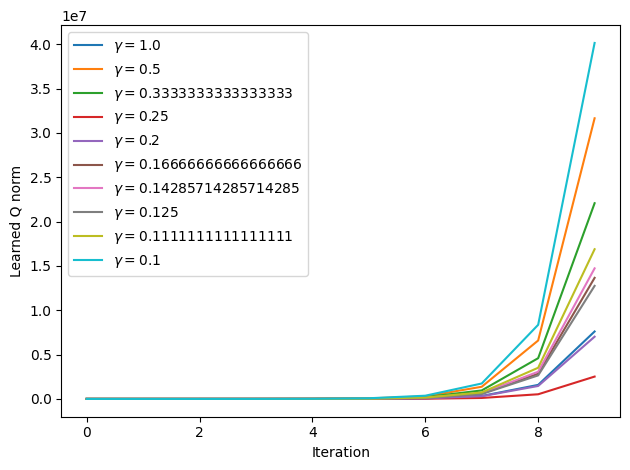

In [32]:
import matplotlib.pyplot as plt

@jax.jit
def compute_targ_Q(mdp: MDP, Q: np.ndarray):
    S, A = Q.shape
    greedy_policy = compute_greedy_policy(Q)
    max_Q = np.sum(greedy_policy * Q, axis=1).reshape(1, 1, S)
    next_v = np.sum(mdp.P * max_Q, axis=-1)
    assert next_v.shape == (S, A)
    return mdp.rew + mdp.gamma * next_v


def fitted_q_iteration(mdp: MDP, gamma):
    d = mdp.phi.shape[-1]
    Q_feature = np.random.randn(d)
    Phi = mdp.phi.reshape(S * A, d)
    Q_norm = []

    for _ in range(10):
        Q = Phi @ Q_feature
        targ_Q = compute_targ_Q(mdp, Q.reshape(S, A)).reshape(S * A)
        Q_feature = np.linalg.inv(Phi.T @ Phi) @ Phi.T @ targ_Q
        Q = mdp.phi @ Q_feature
        Q_norm.append(np.abs(Q).max())
    return Q_norm

for g in range(10):
    gamma = 1 / (g + 1)
    Q_norm = fitted_q_iteration(MDP, gamma)
    plt.plot(Q_norm, label=r"$\gamma=$" + f"{gamma}")
plt.xlabel("Iteration")
plt.ylabel("Learned Q norm")
plt.tight_layout()
plt.legend()

このように、真の価値観数を表現できても、FQIは発散しうることがわかります。これは次の評価指標

$$\epsilon(\mathcal{V}; B) := \sup_{v \in \mathcal{V}}\inf_{v'\in \mathcal{V}} \frac{1}{|S|} \sum_{s \in S} (Bv(s) - v'(s))^2$$

によって関数近似器の自由度が足りているか判断できます。線形近似では$\omega \to \infty$で$\epsilon$が発散します。

### オンライン学習の場合

オンライン学習の場合は、

$$
\omega_{t+1} := \omega_t + \alpha \delta_t \nabla\omega \hat{Q}_{\omega_t}(s_t)
$$
とすれば大丈夫です。これの正当性はQ関数を$\omega_t$周りでテイラー展開すると、ほぼTD方の更新式と同等のものが出てくることから確かめられます。
実際、微小変化 $
\hat{Q}_{\omega_t + \Delta\omega}(s, a) = \hat{Q}_{\omega_t}(s, a) + \Delta \omega^\top \nabla_\omega \hat{Q}_{\omega_t}(s, a) + \mathcal{O}(\|\Delta \omega\|^2_2)
$を考えると、
$$
\hat{Q}_{\omega_{t+1}}(s_t, a_t) \approx \hat{Q}_{\omega_{t}}(s_t, a_t) + \alpha \delta_t \|\nabla_\omega \hat{Q}_{\omega_t}(s_t, a_t)\|^2_2
$$
になります。一方で、異なる状態行動については
$$
\hat{Q}_{\omega_{t+1}}(s', a') \approx \hat{Q}_{\omega_{t}}(s', a') + \alpha \delta_t (\nabla_\omega \hat{Q}_{\omega_t}(s_t, a_t))^\top (\nabla_\omega \hat{Q}_{\omega_t}(s', a'))
$$
であり、関数近似器を適切にパラメータ化しなければ学習効率が悪化します。例えば、線形近似のときを考えてみましょう。このとき、
$$
\hat{Q}_{\omega_{t+1}}(s', a') \approx \hat{Q}_{\omega_{t}}(s', a') + \alpha \delta_t \phi(s_t, a_t)^\top \phi(s', a')
$$
です。 例えば$(s', a')$が(s_t, a_t)とは全然TD誤差を持つ場合、$(s', a')$は連動して更新されるべきではありません。このような場合は$\phi(s_t, a_t)$が$\phi(s', a')$と直行するべきです。

## ベルマン残差を使った方法

上述した更新方法では何らかの目的関数の最小化にもとづいた方法ではありませんでした。その解決案として、次のベルマン残差が考えられます

$$
L_{\text{BR}}(\omega) := \sum_{s, a\in S\times A} \mu(s, a) (\hat{Q}_\omega(s, a) - B\hat{Q}_\omega(s, a))^2
$$

これは$\mathcal{V}$が$V^*$を含む場合、$V^*$はベルマン残差を最小化する唯一の解です。このベルマン残差は線形近似のとき、

$$
L_{\text{BR}}(\omega) := \sum_{s, a\in S\times A} \mu(s, a) \left\{\omega^\top (\phi(s, a) - \gamma \mathbb{E}[\phi(s', a') | s, a]) - r(s, a)\right\}^2
$$
であり、この解は$\omega=A^{-1}b$で得られます。ここで、

$$
A = \sum_{s, a \in S\times A} \mu(s, a) \left(\phi(s, a) - \gamma \mathbb{E}[\phi(s', a') | s, a]\right)\left(\phi(s, a) - \gamma \mathbb{E}[\phi(s', a') | s]\right)^\top
$$

$$
b = \sum_{s, a \in S\times A} \mu(s, a) r(s, a)(\phi(s, a) - \gamma \mathbb{E}[\phi(s', a') | s, a])
$$

です。これは二重サンプリング問題によって実装が難しいことがあるので、次の期待二乗TD誤差を最小化することがあります。

$$
L_{\text{TD}}(\omega) := \sum_{s, a\in S\times A} \mu(s, a) \mathbb{E}\left[\left\{r(s, a) + \gamma \omega^\top \phi(s', a') - \omega^\top \phi(s, a)\right\}^2\right]
$$

よく見るとこれは報酬$r(s, a)$を$\omega^\top (\gamma \phi(s', a') - \phi(s, a))$で近似することに相当します。
一般にこれは$V^\pi \in \mathcal{V}$であっても$L(\omega)_{\text{TD}}$の最小化で$V^\pi$が求まるとは限らないですが、適切な成約のもとでは$V^\pi$に収束します (LSTD法)。
本の図6.5の実験をしてみましょう (面倒なのでベルマン残差だけやります)

In [78]:
import numpy as np
from itertools import product
from functools import partial
from typing import Optional, NamedTuple
import jax.numpy as jnp

S = 2
A = 1
rew = np.zeros((S, A))
P = np.zeros((S, A, S))
P[0, 0, 0] = 0.9
P[0, 0, 1] = 0.1
P[1, 0, 0] = 0.9
P[1, 0, 1] = 0.1
rew[0, 0] = 0
rew[1, 0] = 6
np.testing.assert_almost_equal(P.sum(axis=-1), 1)
rew, P = jnp.array(rew), jnp.array(P)


class MDP(NamedTuple):
    S_array: np.array  # 状態空間
    A_array: np.array  # 行動空間
    gamma: float  # 割引率
    horizon: int  # ホライゾン
    rew: float  # 報酬関数
    P: float  # 遷移確率
    phi: np.array  # 特徴行列
    optimal_Q: Optional[np.ndarray] = None  # 最適Q値
    optimal_Q_idx: Optional[np.ndarray] = None  # 後でplot用に使います

    @property
    def S(self) -> int:  # 状態空間のサイズ
        return len(self.S_array)

    @property
    def A(self) -> int:  # 行動空間のサイズ
        return len(self.A_array)


S_array = np.arange(S)
A_array = np.arange(A)
gamma = 0.5
horizon = int(1 / (1 - gamma))
phi = np.array([[1, 0], [0, 1]])
MDP = MDP(S_array, A_array, gamma, horizon, rew, P, phi)

In [79]:
import matplotlib.pyplot as plt


def sample_next_state(mdp: MDP, s: int, a: int):
    probs = np.array(mdp.P[s, a])
    return np.random.choice(mdp.S_array, p=probs)


def BR_minimization(mdp: MDP):
    d = mdp.phi.shape[-1]
    Phi = mdp.phi.reshape(S, d)

    next_Phi = np.sum(mdp.P * Phi, axis=-1)
    A = np.zeros((d, d))
    for s in range(S):
        X = (Phi - mdp.gamma * next_Phi)[s].reshape(-1, 1)
        A += X @ X.T
    assert A.shape == (d, d)
    A_inv = np.linalg.inv(A)

    b = np.zeros(d)
    for s in range(S):
        b += mdp.rew[s, 0] * (Phi - mdp.gamma * next_Phi)[s]
    Q_feature = A_inv @ b
    assert Q_feature.shape == (d,)
    Q = Phi @ Q_feature
    return Q

Q_BR = BR_minimization(MDP)
print(Q_BR)

[0.6000001 6.6      ]
